         Covid 19 Exploratory Data Analysis (EDA), Visualization and Prediction for Informed Decision Making

                           Importing libraries to be used and reading data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
%matplotlib notebook
%matplotlib inline
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,r2_score


data = pd.read_csv(r"C:\Users\HP\Desktop\Python EDA project\worldometer_data.csv", encoding='utf-8')

ImportError: DLL load failed while importing _path: The specified module could not be found.

                                                  Data Cleaning

In [ ]:
print("Original Data Info:")
print(data.info())

data.describe()


data = data.fillna('-')


data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Population'].fillna(0, inplace=True)
numeric_columns = ['TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered',
                    'ActiveCases', 'Serious,Critical', 'TotalTests']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan).fillna(0)

float_columns = ['Tot Cases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']
data[float_columns] = data[float_columns].apply(pd.to_numeric, errors='coerce')
data[float_columns] = data[float_columns].fillna(0)

# Convert columns to appropriate data types
data['Population'] = data['Population'].astype(int)
data[['TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered',
      'ActiveCases', 'Serious,Critical', 'TotalTests']] = data[['TotalCases', 'NewCases', 'TotalDeaths',
                                                               'NewDeaths', 'TotalRecovered', 'NewRecovered',
                                                               'ActiveCases', 'Serious,Critical', 'TotalTests']].astype(int)

data[['Tot Cases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']] = data[['Tot Cases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']].astype(float)

data.rename(columns={'Serious,Critical': 'Critical Cases'}, inplace=True)



print("\nCleaned Data Info:")
print(data.info())



Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         208 non-null    object 
 2   Population        208 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          4 non-null      float64
 5   TotalDeaths       188 non-null    float64
 6   NewDeaths         3 non-null      float64
 7   TotalRecovered    205 non-null    float64
 8   NewRecovered      3 non-null      float64
 9   ActiveCases       205 non-null    float64
 10  Serious,Critical  122 non-null    float64
 11  Tot Cases/1M pop  208 non-null    float64
 12  Deaths/1M pop     187 non-null    float64
 13  TotalTests        191 non-null    float64
 14  Tests/1M pop      191 non-null    float64
 15  WHO Region        184 non-null    object 
dtypes: float64(12), int64(1)

                                       Saving cleaned Data to a new csv file

In [225]:
data.to_csv('cleaned_data.csv',index = False)

                                    Original Data Visualization using plotly

In [229]:
go.FigureWidget(make_subplots())
# Apply log to cases to reduce difference
data['ActiveCasesLog'] = np.log1p(data['ActiveCases'])

data['TotalRecoveredlog'] = np.log1p(data['TotalRecovered'])
data['TotalDeathslog'] = np.log1p(data['TotalDeaths'])
                                  
data['Population (Millions)'] = data['Population'].apply(lambda x: '{:,.0f}M'.format(x / 1_000_000) if pd.notna(x) else '')

fig = px.choropleth(data, 
                    locations="Country/Region",
                    locationmode="country names",
                    color="ActiveCasesLog",  
                    hover_name="Country/Region",
                    hover_data=["Population (Millions)","TotalCases", "ActiveCases", "TotalRecovered", "TotalDeaths"],
                    color_continuous_scale="reds",
                    title="World Map with COVID-19 Statistics",
                    labels={'ActiveCasesLog': 'Active Cases(log)'},
                    projection="natural earth",  # map projection, e.g., "orthographic", "mercator", 
                    template="plotly_dark"
                    )
fig.update_traces(marker_line_color='darkgrey', marker_line_width=0.5)
fig.update_layout(
    annotations=[
        dict(
            text="Updated As of 8 January 2020",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=-0.5,
            y=1.15,
            font=dict(size=6),
        )
    ]
)

# Creating button menu on map
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            buttons=list([
                dict(label="Active Cases",
                     method="update",
                     args=[{"visible": [True, False, False]},
                           {"title": "COVID-19 Active Cases by Country"}],
                     ),  
                dict(label="Total Recovered",
                     method="update",
                     args=[{"visible": [False, True, False]},
                           {"title": "COVID-19 Total Recovered by Country"}],
                   ),  
                dict(label="Total Deaths",
                     method="update",
                     args=[{"visible": [False, False, True]},
                           {"title": "COVID-19 Total Deaths by Country"}],
                     ),  
            ]),
        )
    ])

# Create trace for 'TotalRecovered'
trace_total_recovered = px.choropleth(data,
                                      locations="Country/Region",
                                      locationmode="country names",
                                      color="TotalRecoveredlog",
                                      color_continuous_scale="greens", 
                                      projection="natural earth",
                                      template="plotly_dark",
                                      ).update_coloraxes(colorbar_title='Total Recovered')  

# Create trace for 'TotalDeaths'
trace_total_deaths = px.choropleth(data,
                                   locations="Country/Region",
                                   locationmode="country names",
                                   color="TotalDeathslog",
                                   color_continuous_scale="twilight", 
                                   projection="natural earth",
                                   template="plotly_dark",
                                   ).update_coloraxes(colorbar_title='Total Deaths') 


fig.add_trace(trace_total_recovered.data[0])
fig.add_trace(trace_total_deaths.data[0])


fig.update_layout(
    geo=dict(
        projection_scale=1,
        center=dict(lon=0, lat=0),
    )
)

pio.write_html(fig, file='Covid-19 cases.html', auto_open=False)

fig.show()

                                                  Data Insights

1. The following graph show the overall trend in the total number of cases in each country


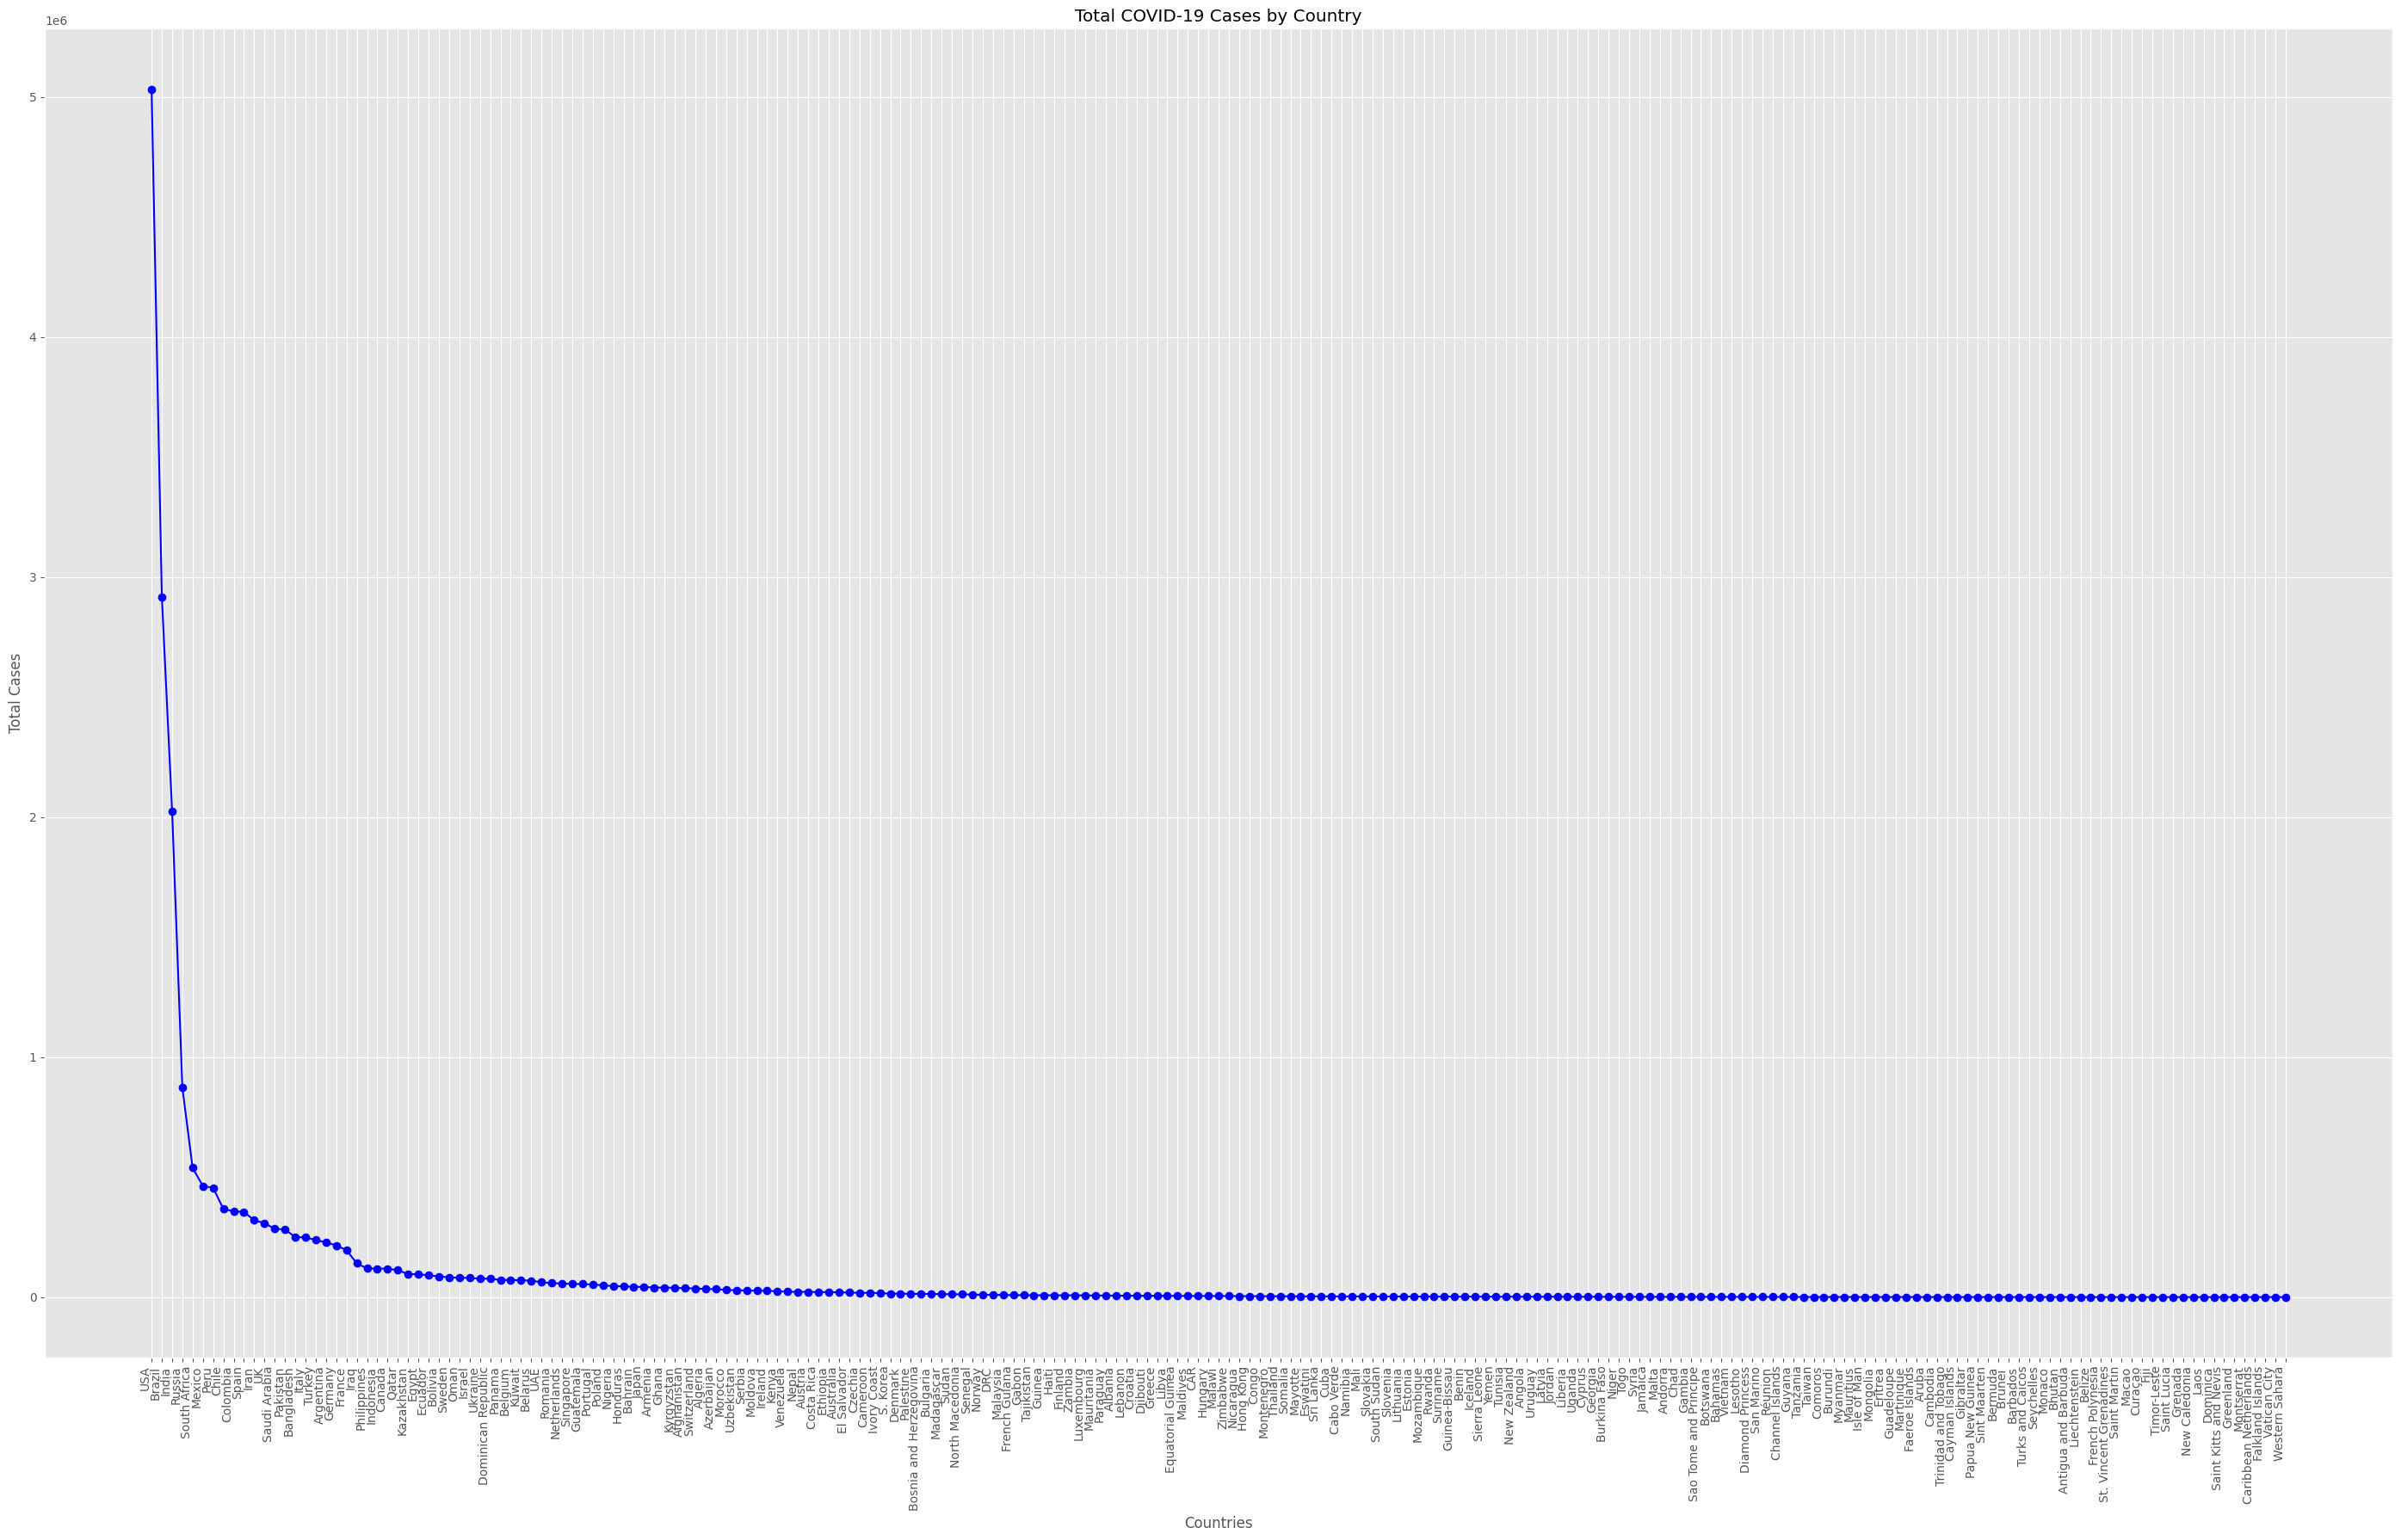

2. The total number of cases across each continent


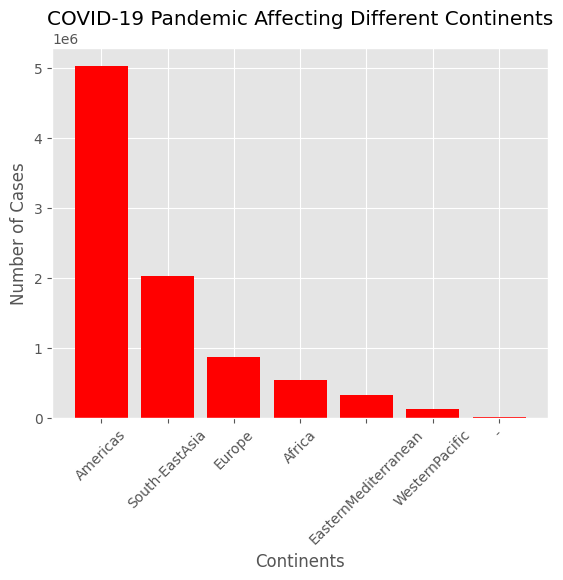

3. Countries with Highest & Lowest Number of Total Cases: 
Highest Cases: 0    USA
Name: Country/Region, dtype: object, Total Cases: 0    5032179
Name: TotalCases, dtype: int32

Lowest Cases:  208    Western Sahara
Name: Country/Region, dtype: object, Total Cases: 208    10
Name: TotalCases, dtype: int32





4. Countries with higher ratio of deaths and critical cases as compared to population


C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




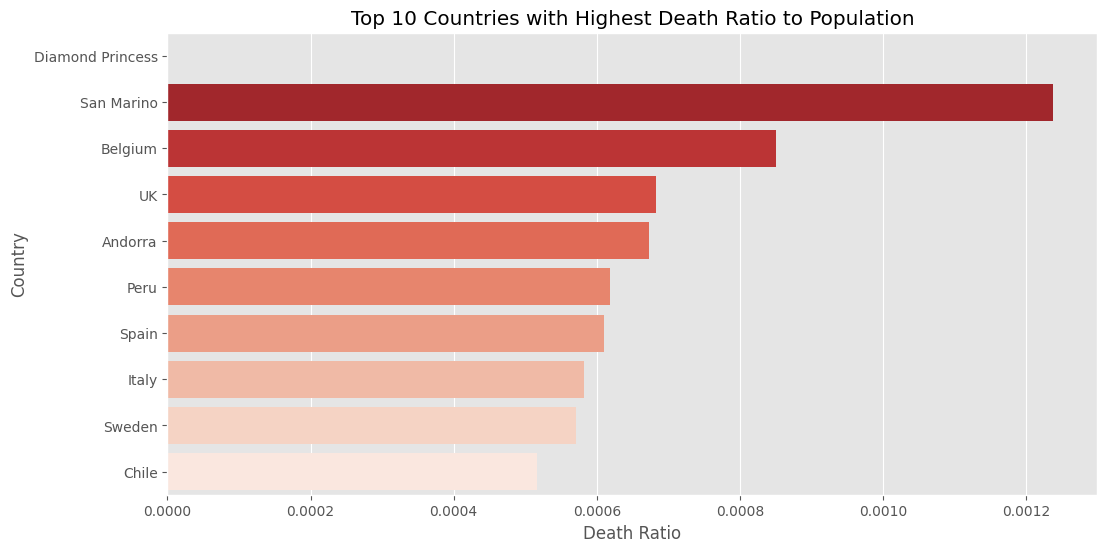

C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:53: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




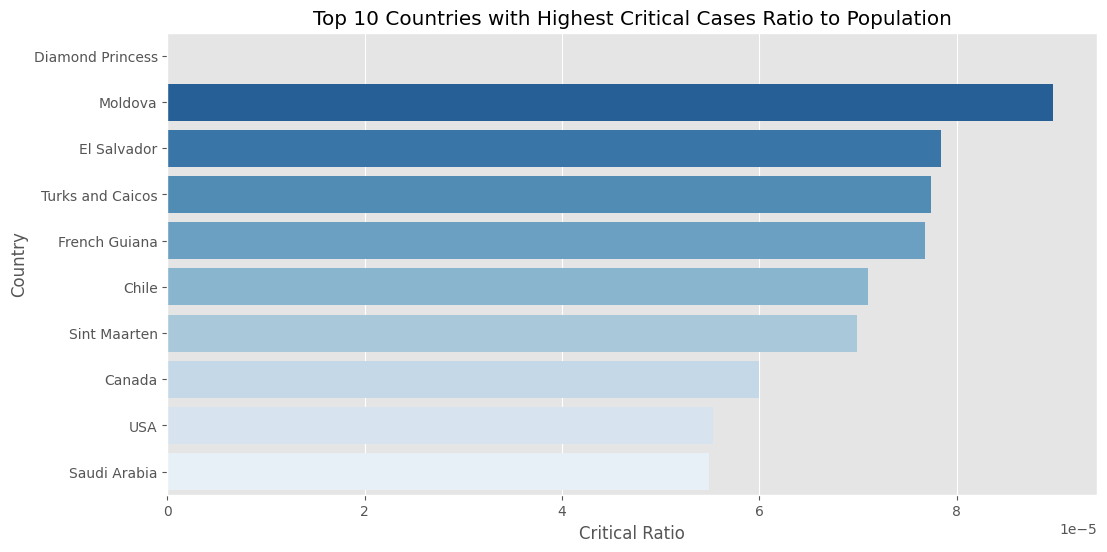


5. Top 10 countries with highest ratio of critical cases to total cases


C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:64: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




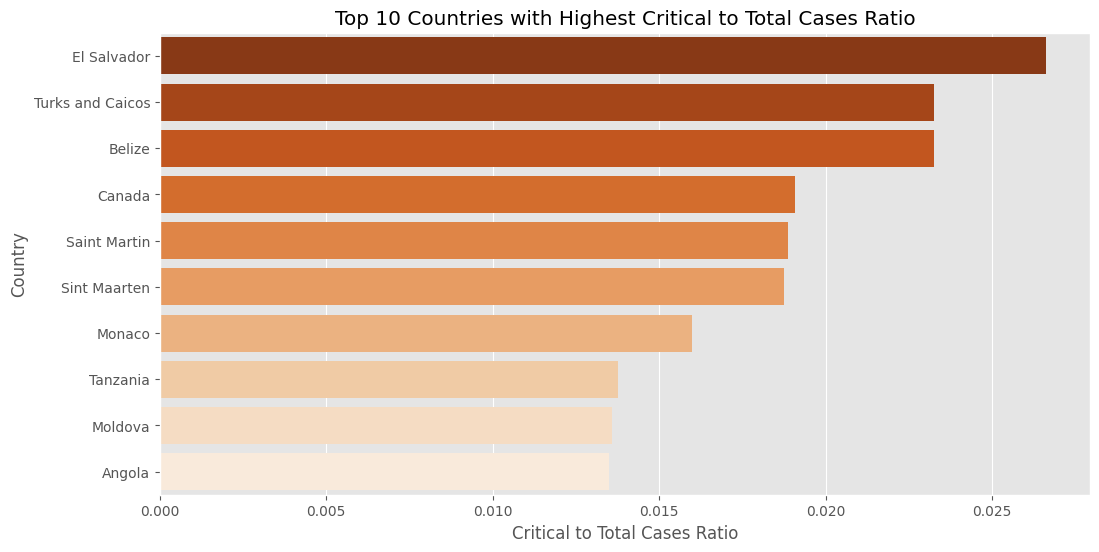


6. Comparison between top 10 countries for total deaths


C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:73: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




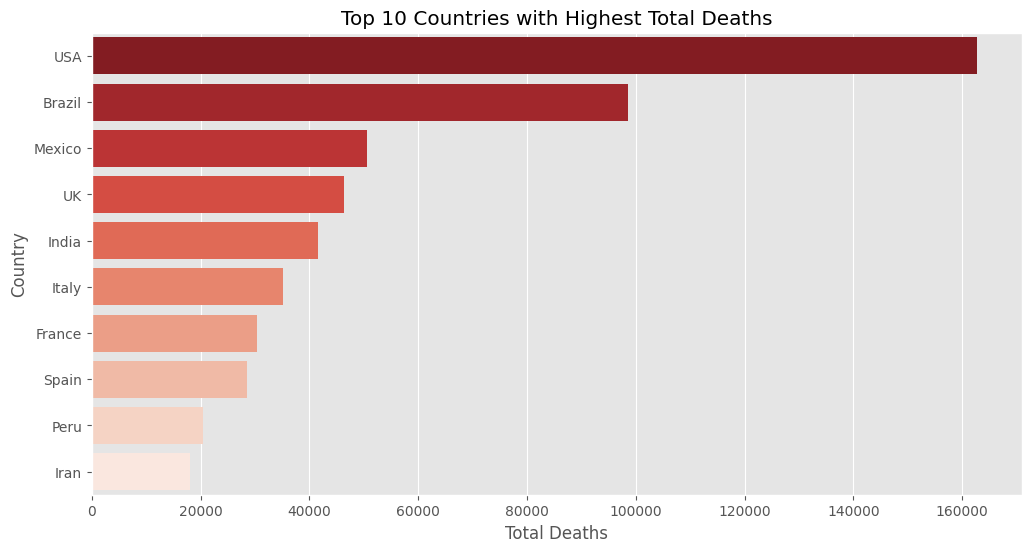


7. Top 5 Countries with Highest & Lowest Recovery Rates: 


C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:83: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




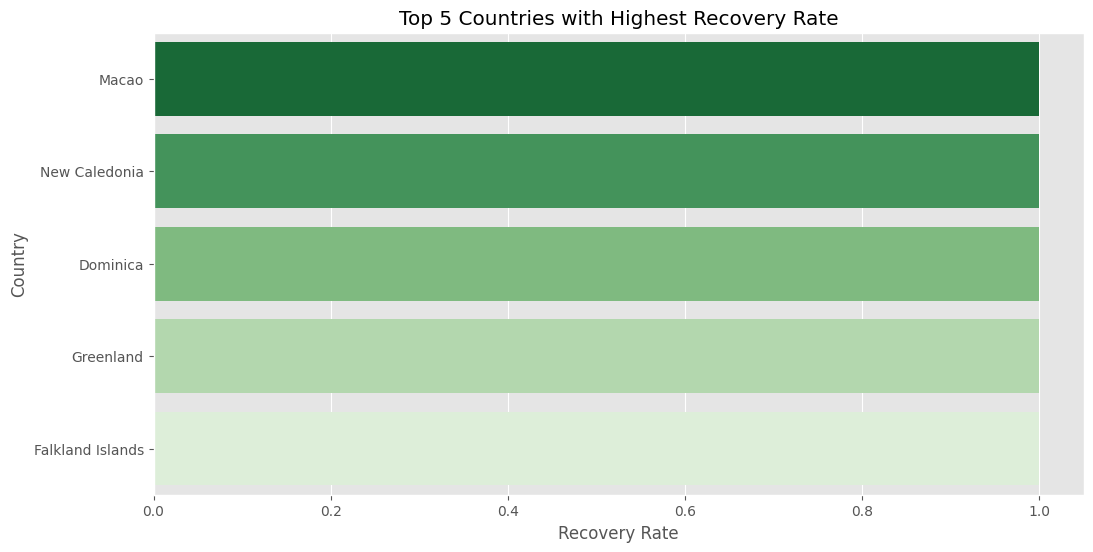

C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:90: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




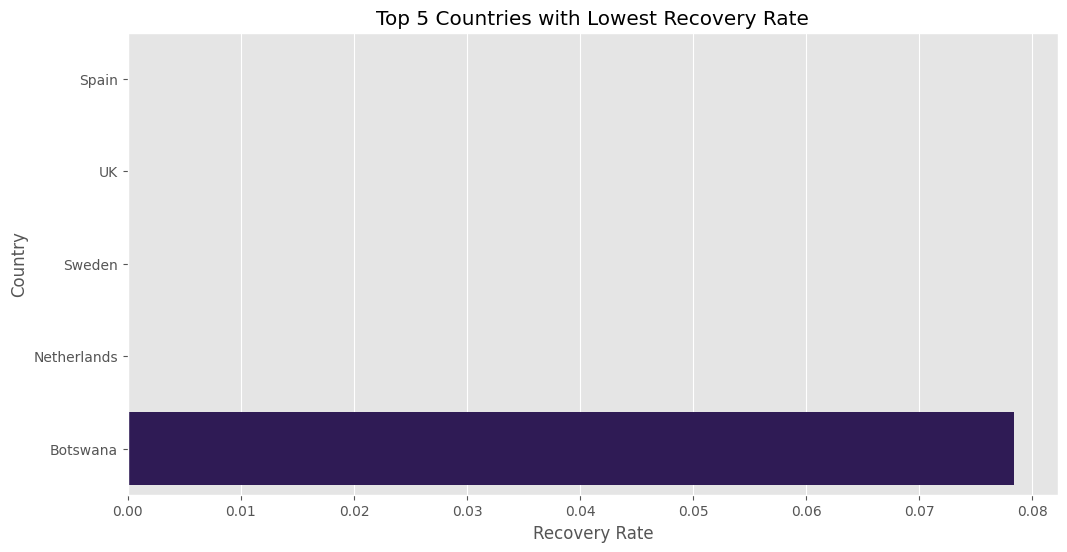


8. The ratio of recoveries to the total cases in each country.


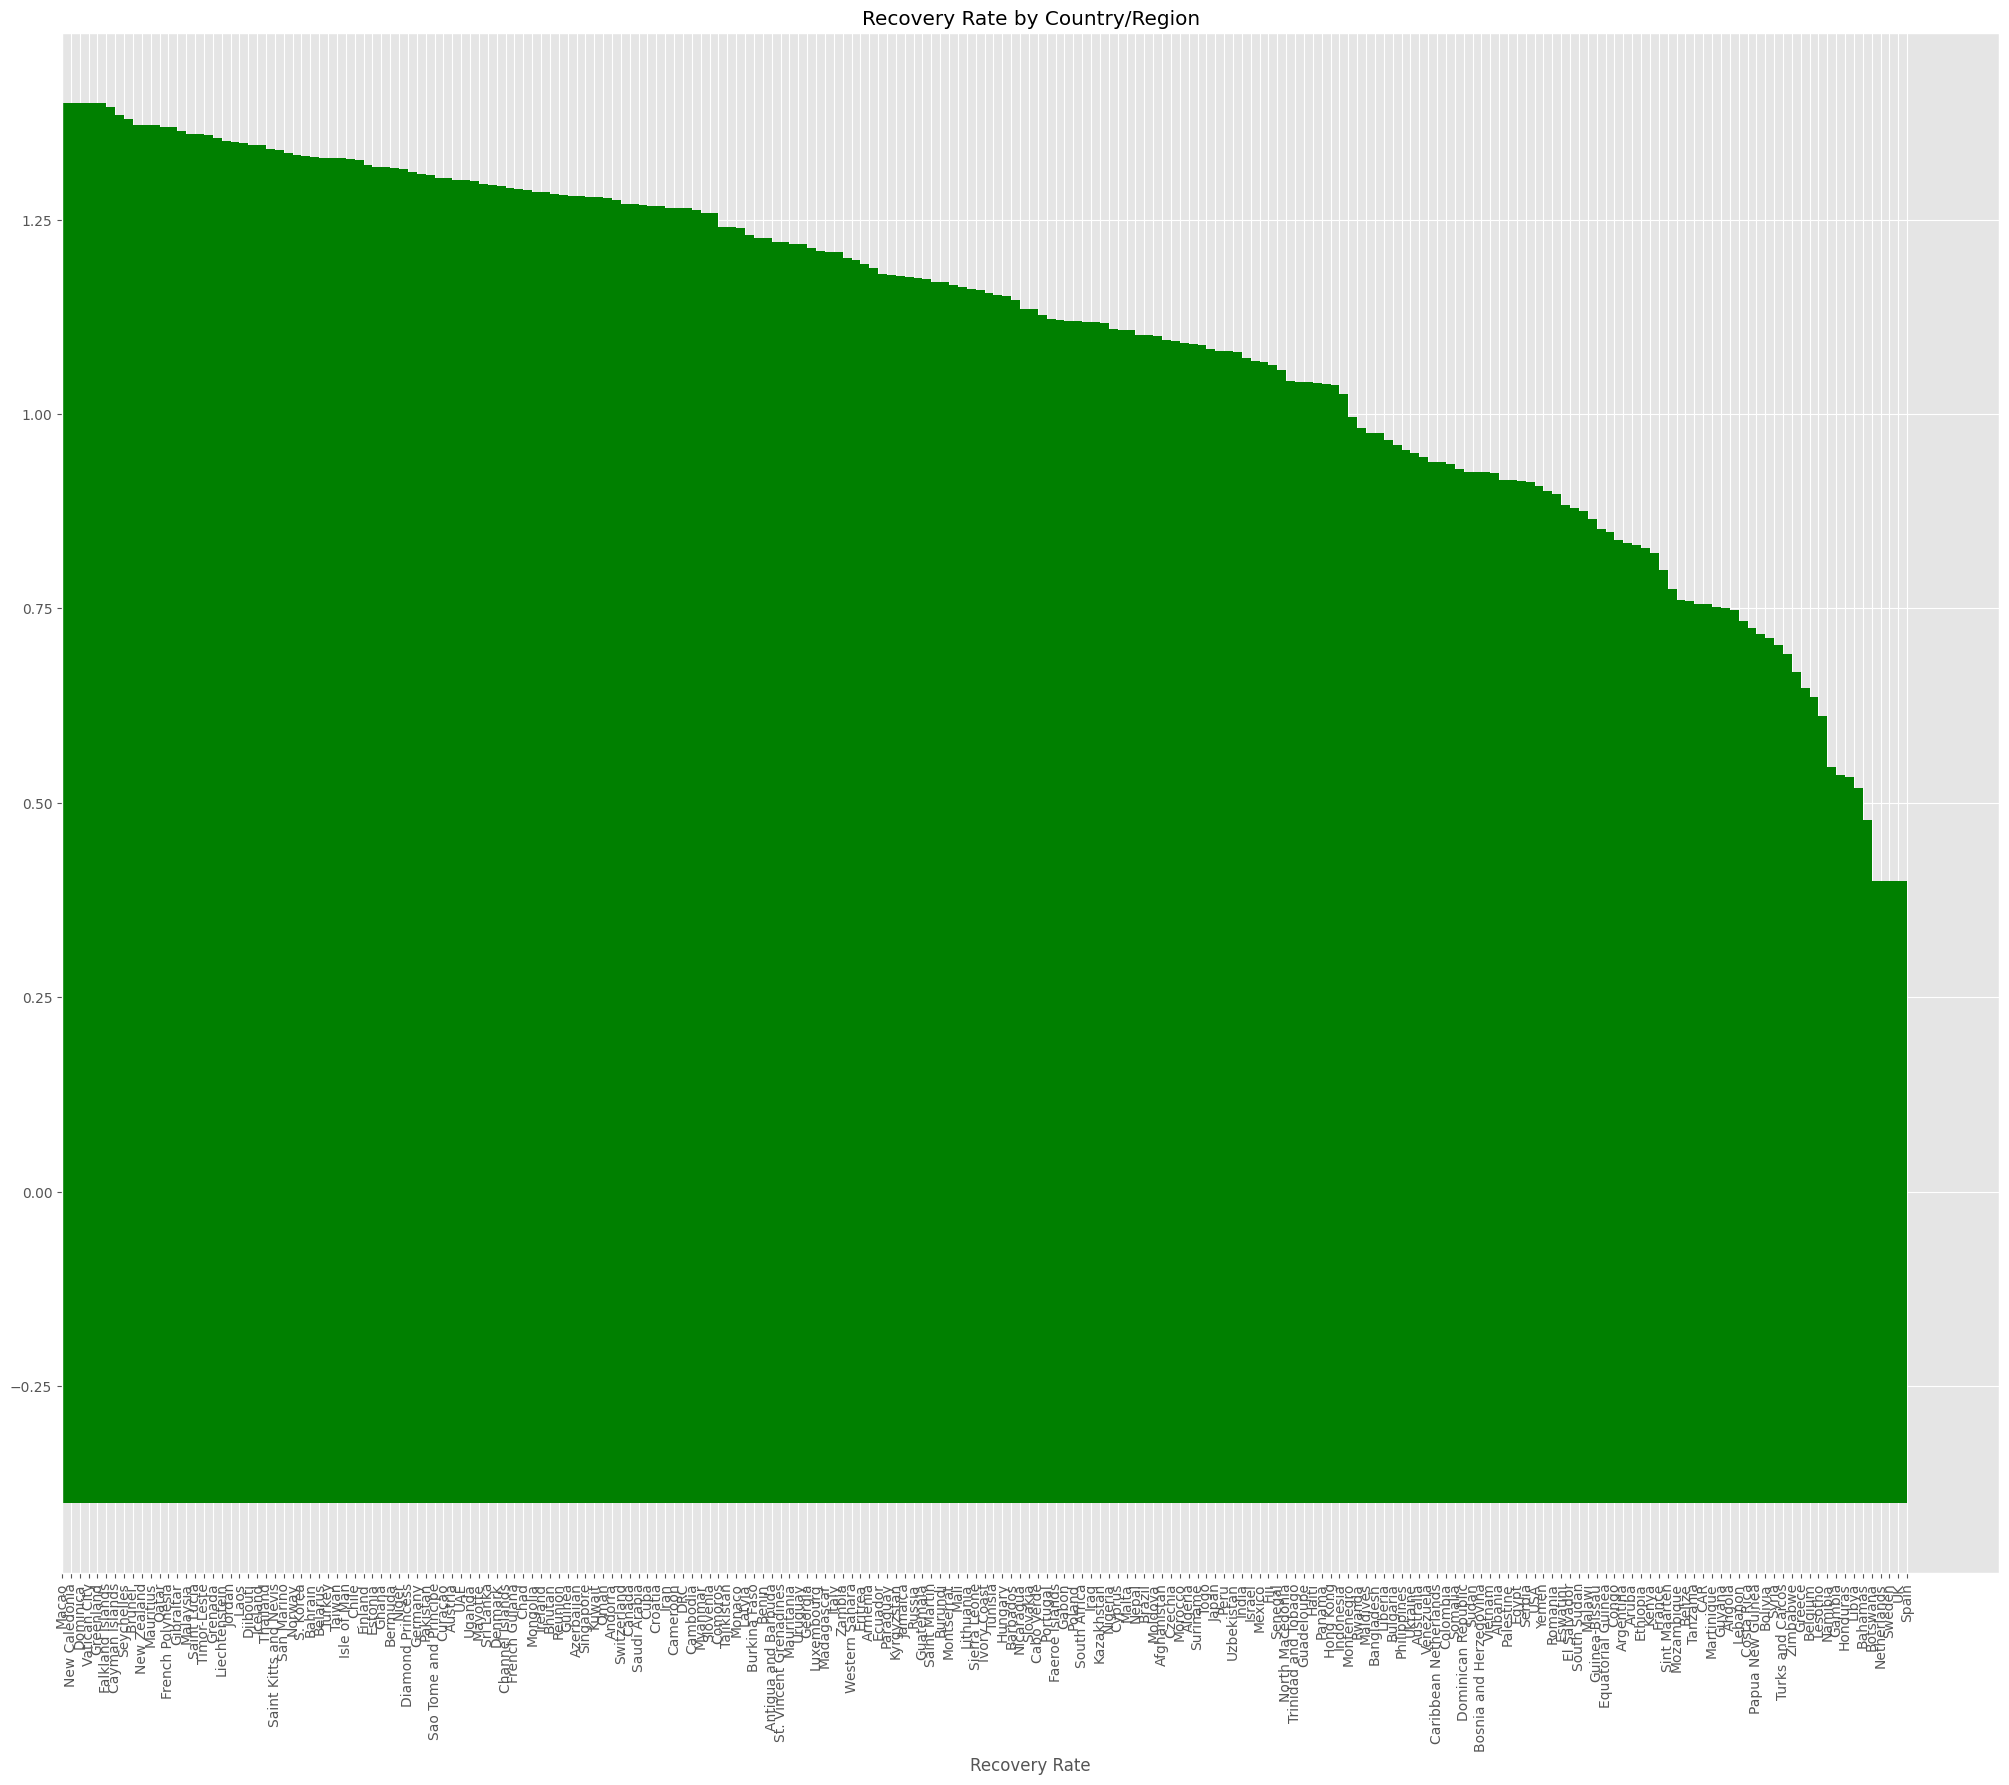


9. Testing Coverage by Country (total tests)


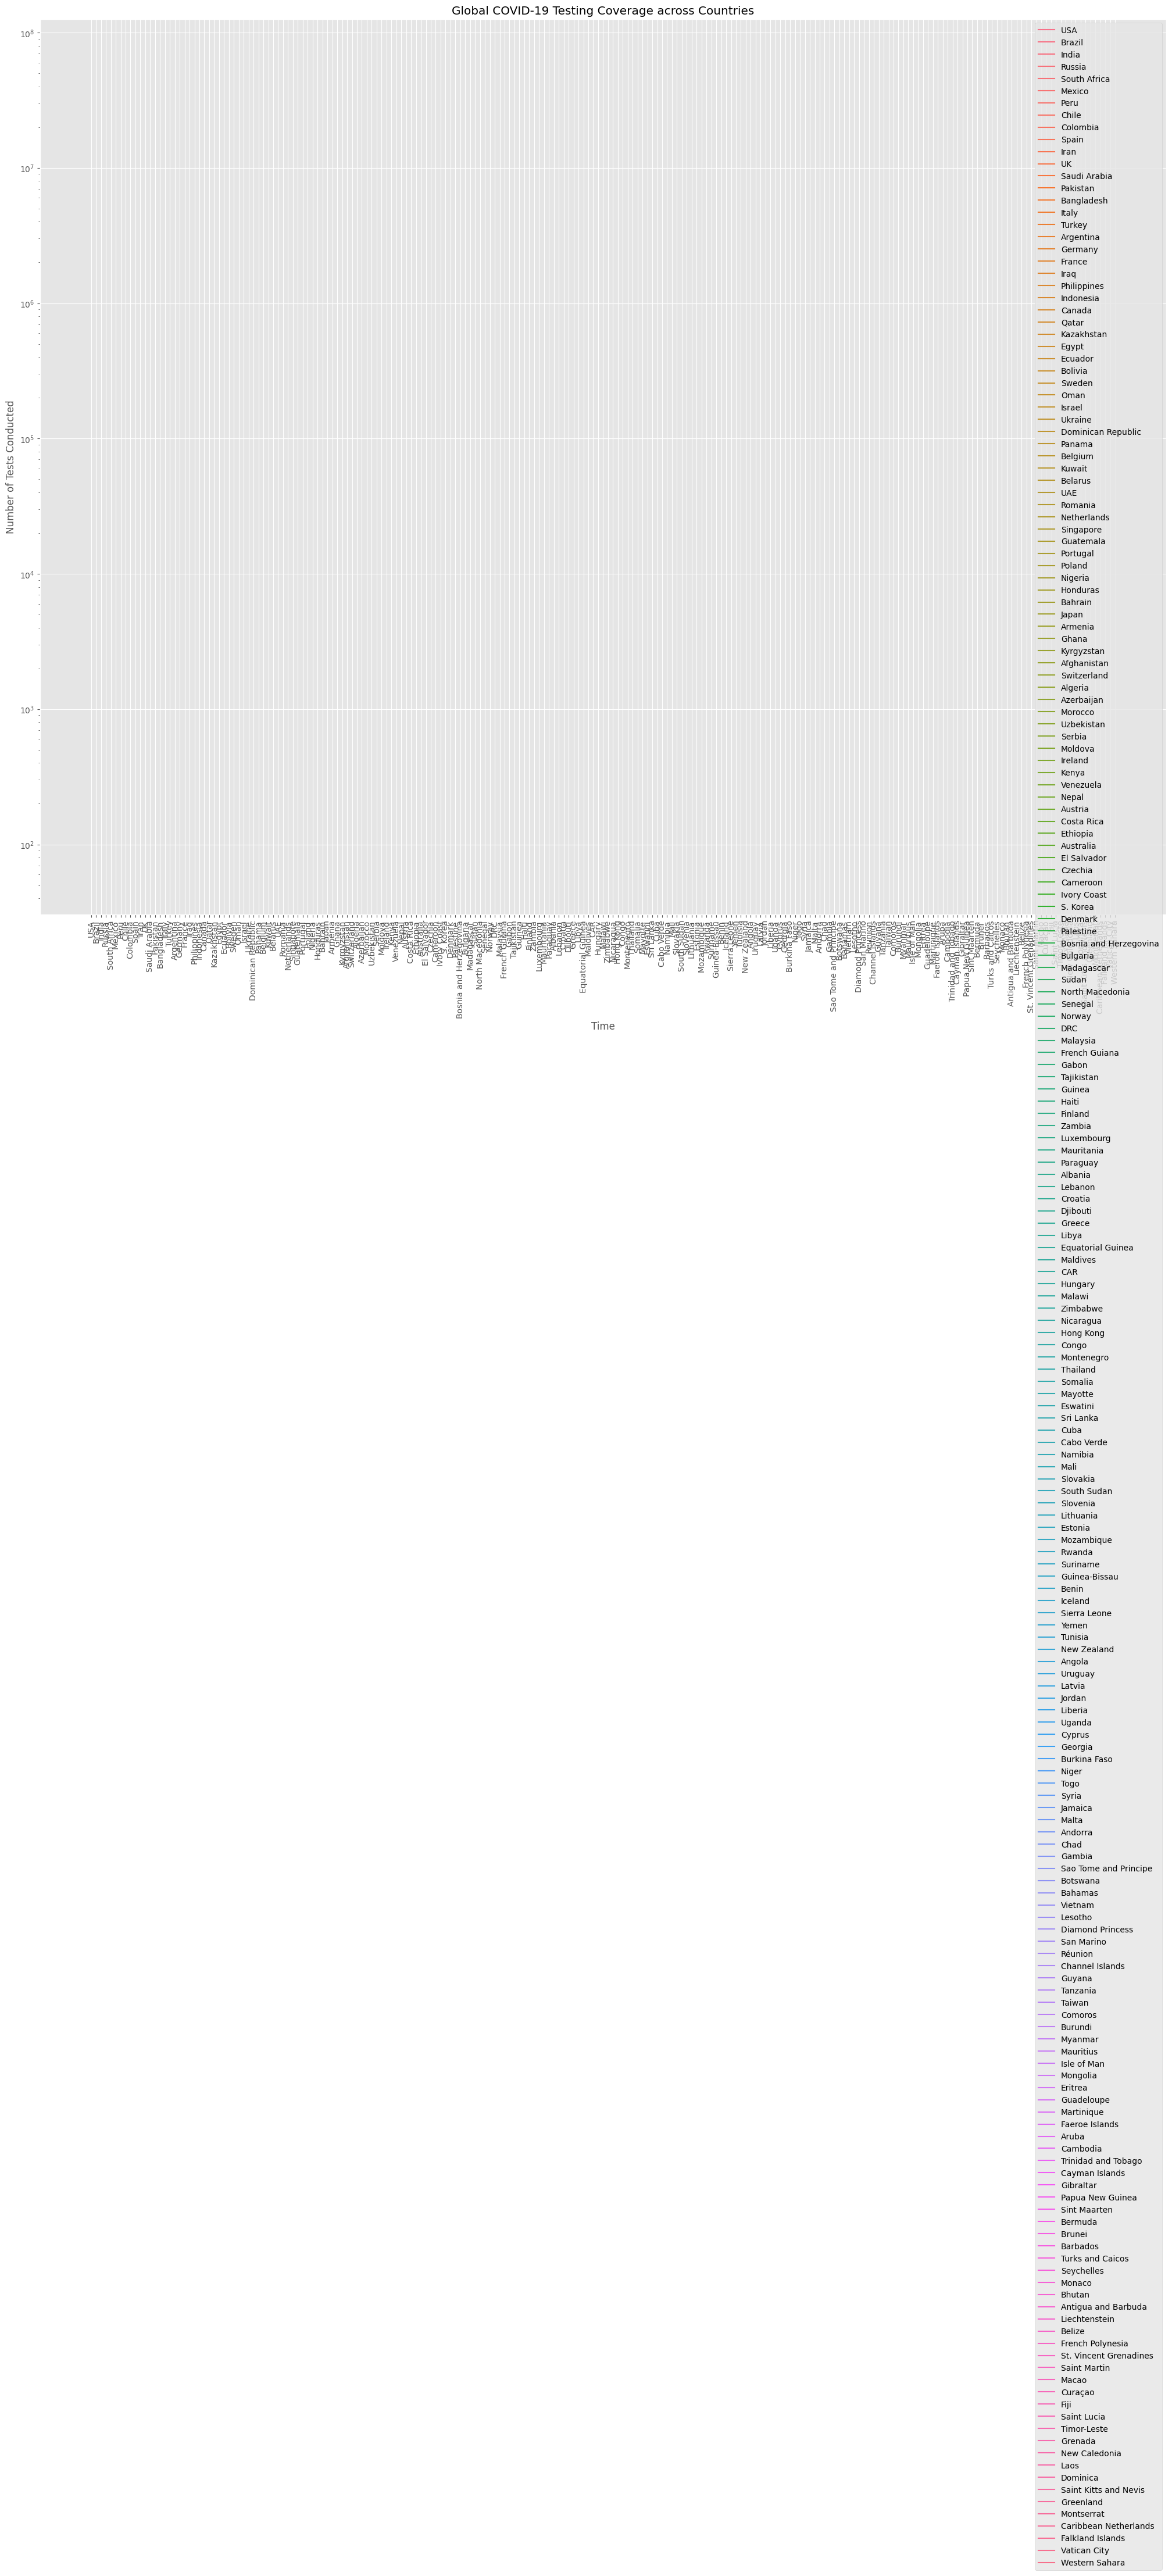


10. Top 10 countries with highest Number of COVID-19 Cases Per Million People


C:\Users\HP\AppData\Local\Temp\ipykernel_19916\3998034014.py:128: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




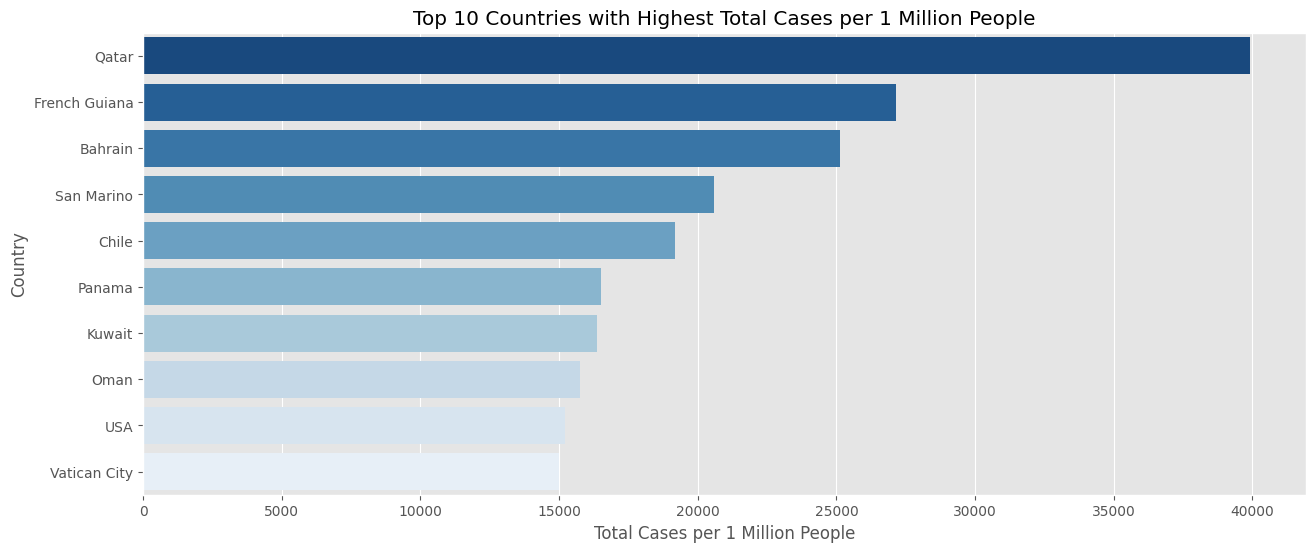


11. Variations in Deaths per 1 Million People Across Regions


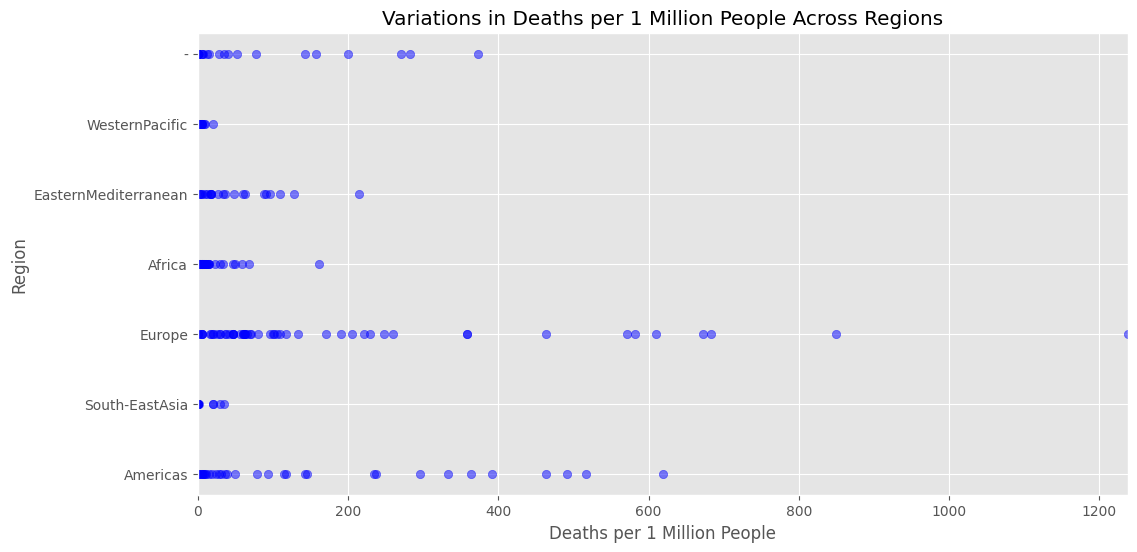


12. Correlation Between Population Size and Number of Cases of each country


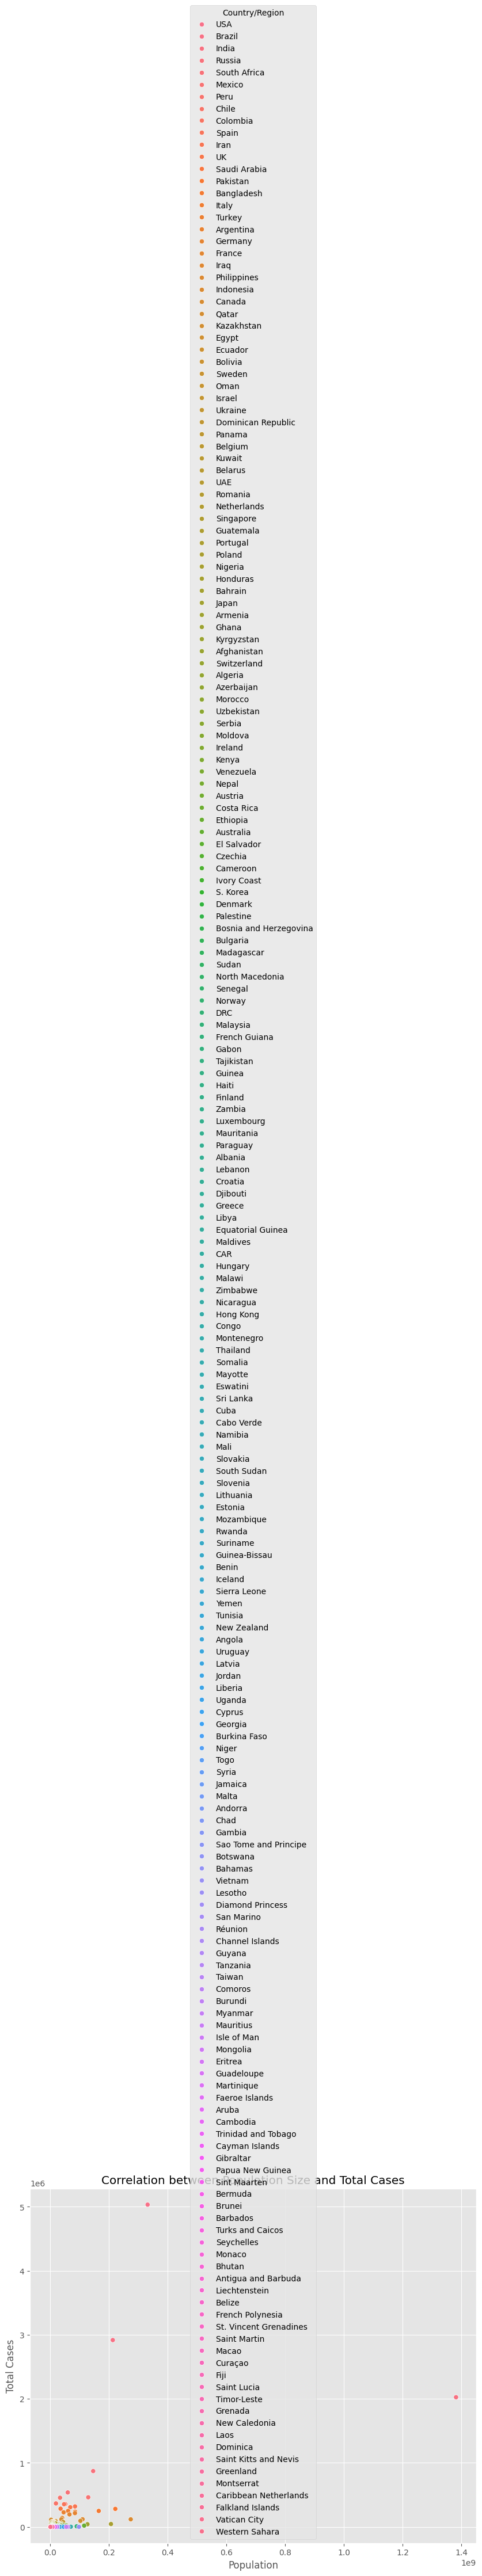


13. Major Milestones in Pandemic Progression
Highest number of Active Cases: 
2292707
Lowest number of Active Cases: 
0


In [230]:

# 1. What is the overall trend in the number of COVID-19 cases globally?
print("1. The following graph show the overall trend in the total number of cases in each country")
sorteddata = data.sort_values(by='TotalCases', ascending=False)

plt.figure(figsize=(28, 18))


plt.plot(sorteddata['Country/Region'], sorteddata['TotalCases'], marker='o', linestyle='-', color='b')


plt.xlabel('Countries')
plt.ylabel('Total Cases')
plt.title('Total COVID-19 Cases by Country')

plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()
    

# 2. How has the pandemic affected different continents?

print("2. The total number of cases across each continent")


plt.bar(data['WHO Region'], data['TotalCases'],color = 'red')
plt.xlabel('Continents')
plt.ylabel('Number of Cases')
plt.title('COVID-19 Pandemic Affecting Different Continents')
plt.xticks(rotation=45) 
plt.show()

# 3. Which countries have the highest and lowest total cases?
print("3. Countries with Highest & Lowest Number of Total Cases: ")
highestcases = data[data['TotalCases'] == data['TotalCases'].max()]
lowestcases = data[data['TotalCases'] == data['TotalCases'].min()]
print(f"Highest Cases: {highestcases['Country/Region']}, Total Cases: {highestcases['TotalCases']}")
print(f"\nLowest Cases:  {lowestcases['Country/Region']}, Total Cases: {lowestcases['TotalCases']}")

# 4. In Which countries the number of deaths or critical cases have a higher ratio to their population than other countries?
print("\n\n\n\n\n4. Countries with higher ratio of deaths and critical cases as compared to population")
data['DeathRatio'] = data['TotalDeaths'] / data['Population']
data['CriticalRatio'] = data['Critical Cases'] / data['Population']

plt.figure(figsize=(12, 6))
sns.barplot(x='DeathRatio', y='Country/Region', data=data.nlargest(10, 'DeathRatio'), palette='Reds_r')
plt.title('Top 10 Countries with Highest Death Ratio to Population')
plt.xlabel('Death Ratio')
plt.ylabel('Country')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='CriticalRatio', y='Country/Region', data=data.nlargest(10, 'CriticalRatio'), palette='Blues_r')
plt.title('Top 10 Countries with Highest Critical Cases Ratio to Population')
plt.xlabel('Critical Ratio')
plt.ylabel('Country')
plt.show()

# 5. What is the ratio of critical cases to total cases in different countries?
print("\n5. Top 10 countries with highest ratio of critical cases to total cases")
data['CriticalToTotalRatio'] = data['Critical Cases'] / data['TotalCases']

plt.figure(figsize=(12, 6))
sns.barplot(x='CriticalToTotalRatio', y='Country/Region', data=data.nlargest(10, 'CriticalToTotalRatio'), palette='Oranges_r')
plt.title('Top 10 Countries with Highest Critical to Total Cases Ratio')
plt.xlabel('Critical to Total Cases Ratio')
plt.ylabel('Country')
plt.show()

# 6. How do the total deaths compare across countries?
print("\n6. Comparison between top 10 countries for total deaths")
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalDeaths', y='Country/Region', data=data.nlargest(10, 'TotalDeaths'), palette='Reds_r')
plt.title('Top 10 Countries with Highest Total Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()
# 7. Which countries have the highest and lowest recovery rates?
print("\n7. Top 5 Countries with Highest & Lowest Recovery Rates: ")
data['RecoveryRate'] = data['TotalRecovered'] / data['TotalCases']

plt.figure(figsize=(12, 6))
sns.barplot(x='RecoveryRate', y='Country/Region', data=data.nlargest(5, 'RecoveryRate'), palette='Greens_r')
plt.title('Top 5 Countries with Highest Recovery Rate')
plt.xlabel('Recovery Rate')
plt.ylabel('Country')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='RecoveryRate', y='Country/Region', data=data.nsmallest(5, 'RecoveryRate'), palette='magma_r')
plt.title('Top 5 Countries with Lowest Recovery Rate')
plt.xlabel('Recovery Rate')
plt.ylabel('Country')
plt.show()

# 8. What is the ratio of recoveries to the total cases in each country?
print("\n8. The ratio of recoveries to the total cases in each country.")
data['RecoveryRate'] = data['TotalRecovered'] / data['TotalCases']

# Sort the dataframe by RecoveryRate for better visualization
data_sorted = data.sort_values(by='RecoveryRate', ascending=False)


plt.figure(figsize=(25, 20))
plt.barh(data_sorted['RecoveryRate'],data_sorted['Country/Region'], color='green')
plt.xticks(rotation = 90)
plt.xlabel('Recovery Rate')
plt.title('Recovery Rate by Country/Region')
plt.show()

# 9. What is the testing coverage in terms of total tests conducted?
print("\n9. Testing Coverage by Country (total tests)")
plt.figure(figsize=(25, 20))
sns.lineplot(x="Country/Region", y="TotalTests", hue="Country/Region", data=data)
plt.title("Global COVID-19 Testing Coverage across Countries")
plt.xlabel("Time")
plt.ylabel("Number of Tests Conducted")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.gca().set_yscale("log")
plt.savefig("covid_testing_coverage.png")
plt.show()


# 10. What is the total number of cases per 1 million people in various countries?
print("\n10. Top 10 countries with highest Number of COVID-19 Cases Per Million People")
plt.figure(figsize=(15, 6))
sns.barplot(x='Tot Cases/1M pop', y='Country/Region', data=data.nlargest(10, 'Tot Cases/1M pop'), palette='Blues_r')
plt.title('Top 10 Countries with Highest Total Cases per 1 Million People')
plt.xlabel('Total Cases per 1 Million People')
plt.ylabel('Country')
plt.show()
# 11. How do total deaths per 1 million people vary across different regions?
print("\n11. Variations in Deaths per 1 Million People Across Regions")
plt.figure(figsize=(12, 6))
plt.scatter(x=data['Deaths/1M pop'], y=data['WHO Region'], color='blue', alpha=0.5)
plt.xlim([0, max(data['Deaths/1M pop'])])
plt.title('Variations in Deaths per 1 Million People Across Regions')
plt.xlabel('Deaths per 1 Million People')
plt.ylabel('Region')

# Show the plot
plt.show()
# 12. Are there any correlations between population size and the number of cases?
print("\n12. Correlation Between Population Size and Number of Cases of each country")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Population', y='TotalCases',hue = 'Country/Region', data=data)
plt.title('Correlation between Population Size and Total Cases')
plt.xlabel('Population')
plt.ylabel('Total Cases')
plt.show()
# 13. What have been the major milestones in the pandemic’s progression?
print("\n13. Major Milestones in Pandemic Progression")
print("Highest number of Active Cases: ")
print(max(data['ActiveCases']))
print("Lowest number of Active Cases: ")
print(min(data['ActiveCases']))

# 14. How does the pandemic’s impact differ between Most and least developed Countries?
# print("\n\n14. Impact Differences between Most Developed and Least Developed Countries")
# most_developed_countries = ['USA', 'France', 'UAE', 'Germany', 'Japan']
# data_most_developed = data[data['Country/Region'].isin(most_developed_countries)]

# plt.figure(figsize=(12, 8))

# heatmap_data = data_most_developed.pivot_table(values='TotalDeaths', index='Country/Region', columns='TotalCases')

# sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='g', linewidths=.5)

# plt.title('Heatmap of Total Deaths vs Total Cases in Top 5 Most Developed Countries')
# plt.show()

# least_developed_countries = ['Pakistan', 'India', 'Bangladesh', 'Nigeria', 'Ethiopia']
# data_least_developed = data[data['Country/Region'].isin(least_developed_countries)]

# plt.figure(figsize=(12, 8))

# heatmap_data_least_developed = data_least_developed.pivot_table(values='TotalDeaths', index='Country/Region', columns='TotalCases')

# sns.heatmap(heatmap_data_least_developed, cmap='viridis', annot=True, fmt='g', linewidths=.5)

# plt.title('Heatmap of Total Deaths vs Total Cases in Top 5 Least Developed Countries')
# plt.show()



  Applying KNN to predict 'Active Cases' for countries that are missing this data based upon their 'TotalCases', 'TotalDeaths',    'TotalRecovered', 'Critical Cases', and 'TotalTests'.   

In [ ]:

knncolumns = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'Critical Cases', 'TotalTests', 'Population', 'ActiveCases']


data[knncolumns] = data[knncolumns].replace(0, float('nan'))


train_data = data.dropna(subset=['ActiveCases'])
test_data = data[data['ActiveCases'].isnull()]


X_train = train_data[knncolumns].drop('ActiveCases', axis=1)
y_train = train_data['ActiveCases']


X_test = test_data[knncolumns].drop('ActiveCases', axis=1)


X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

imputer = KNNImputer(n_neighbors=5)
X_imputed_train = imputer.fit_transform(X_train)
X_imputed_test = imputer.transform(X_test)

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_imputed_train, y_train)


predicted_active_cases = knn_regressor.predict(X_imputed_test)

# Fill missing values in the 'Active Cases (Predicted)' column
data.loc[data['ActiveCases'].isnull(), 'Active Cases (Predicted)'] = predicted_active_cases

y_train_pred = knn_regressor.predict(X_imputed_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred) # max is 1

print(f'Mean Squared Error on the training set: {mse}')
print(f'R2 Score on the training set: {r2}')

print(data)


Mean Squared Error on the training set: 18653229223.786182
R2 Score on the training set: 0.4175002978073671
            Country/Region      Continent    Population  TotalCases  NewCases  \
0                      USA  North America   331,198,130     5032179         0   
1                   Brazil  South America   212,710,692     2917562         0   
2                    India           Asia 1,381,344,997     2025409         0   
3                   Russia         Europe   145,940,924      871894         0   
4             South Africa         Africa    59,381,566      538184         0   
..                     ...            ...           ...         ...       ...   
204             Montserrat  North America         4,992          13         0   
205  Caribbean Netherlands  North America        26,247          13         0   
206       Falkland Islands  South America         3,489          13         0   
207           Vatican City         Europe           801          12         0   
2

Mean Squared Error on the training set: 18653229223.786182
R2 Score on the training set: 0.4175002978073671
            Country/Region      Continent    Population  TotalCases  NewCases  \
0                      USA  North America   331,198,130     5032179         0   
1                   Brazil  South America   212,710,692     2917562         0   
2                    India           Asia 1,381,344,997     2025409         0   
3                   Russia         Europe   145,940,924      871894         0   
4             South Africa         Africa    59,381,566      538184         0   
..                     ...            ...           ...         ...       ...   
204             Montserrat  North America         4,992          13         0   
205  Caribbean Netherlands  North America        26,247          13         0   
206       Falkland Islands  South America         3,489          13         0   
207           Vatican City         Europe           801          12         0   
2

       Finding Similarity in number of cases between countries using K-Means Clustering and visualizing them.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users

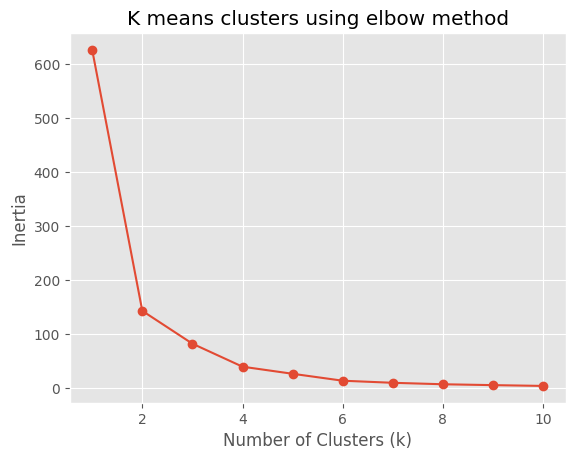

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



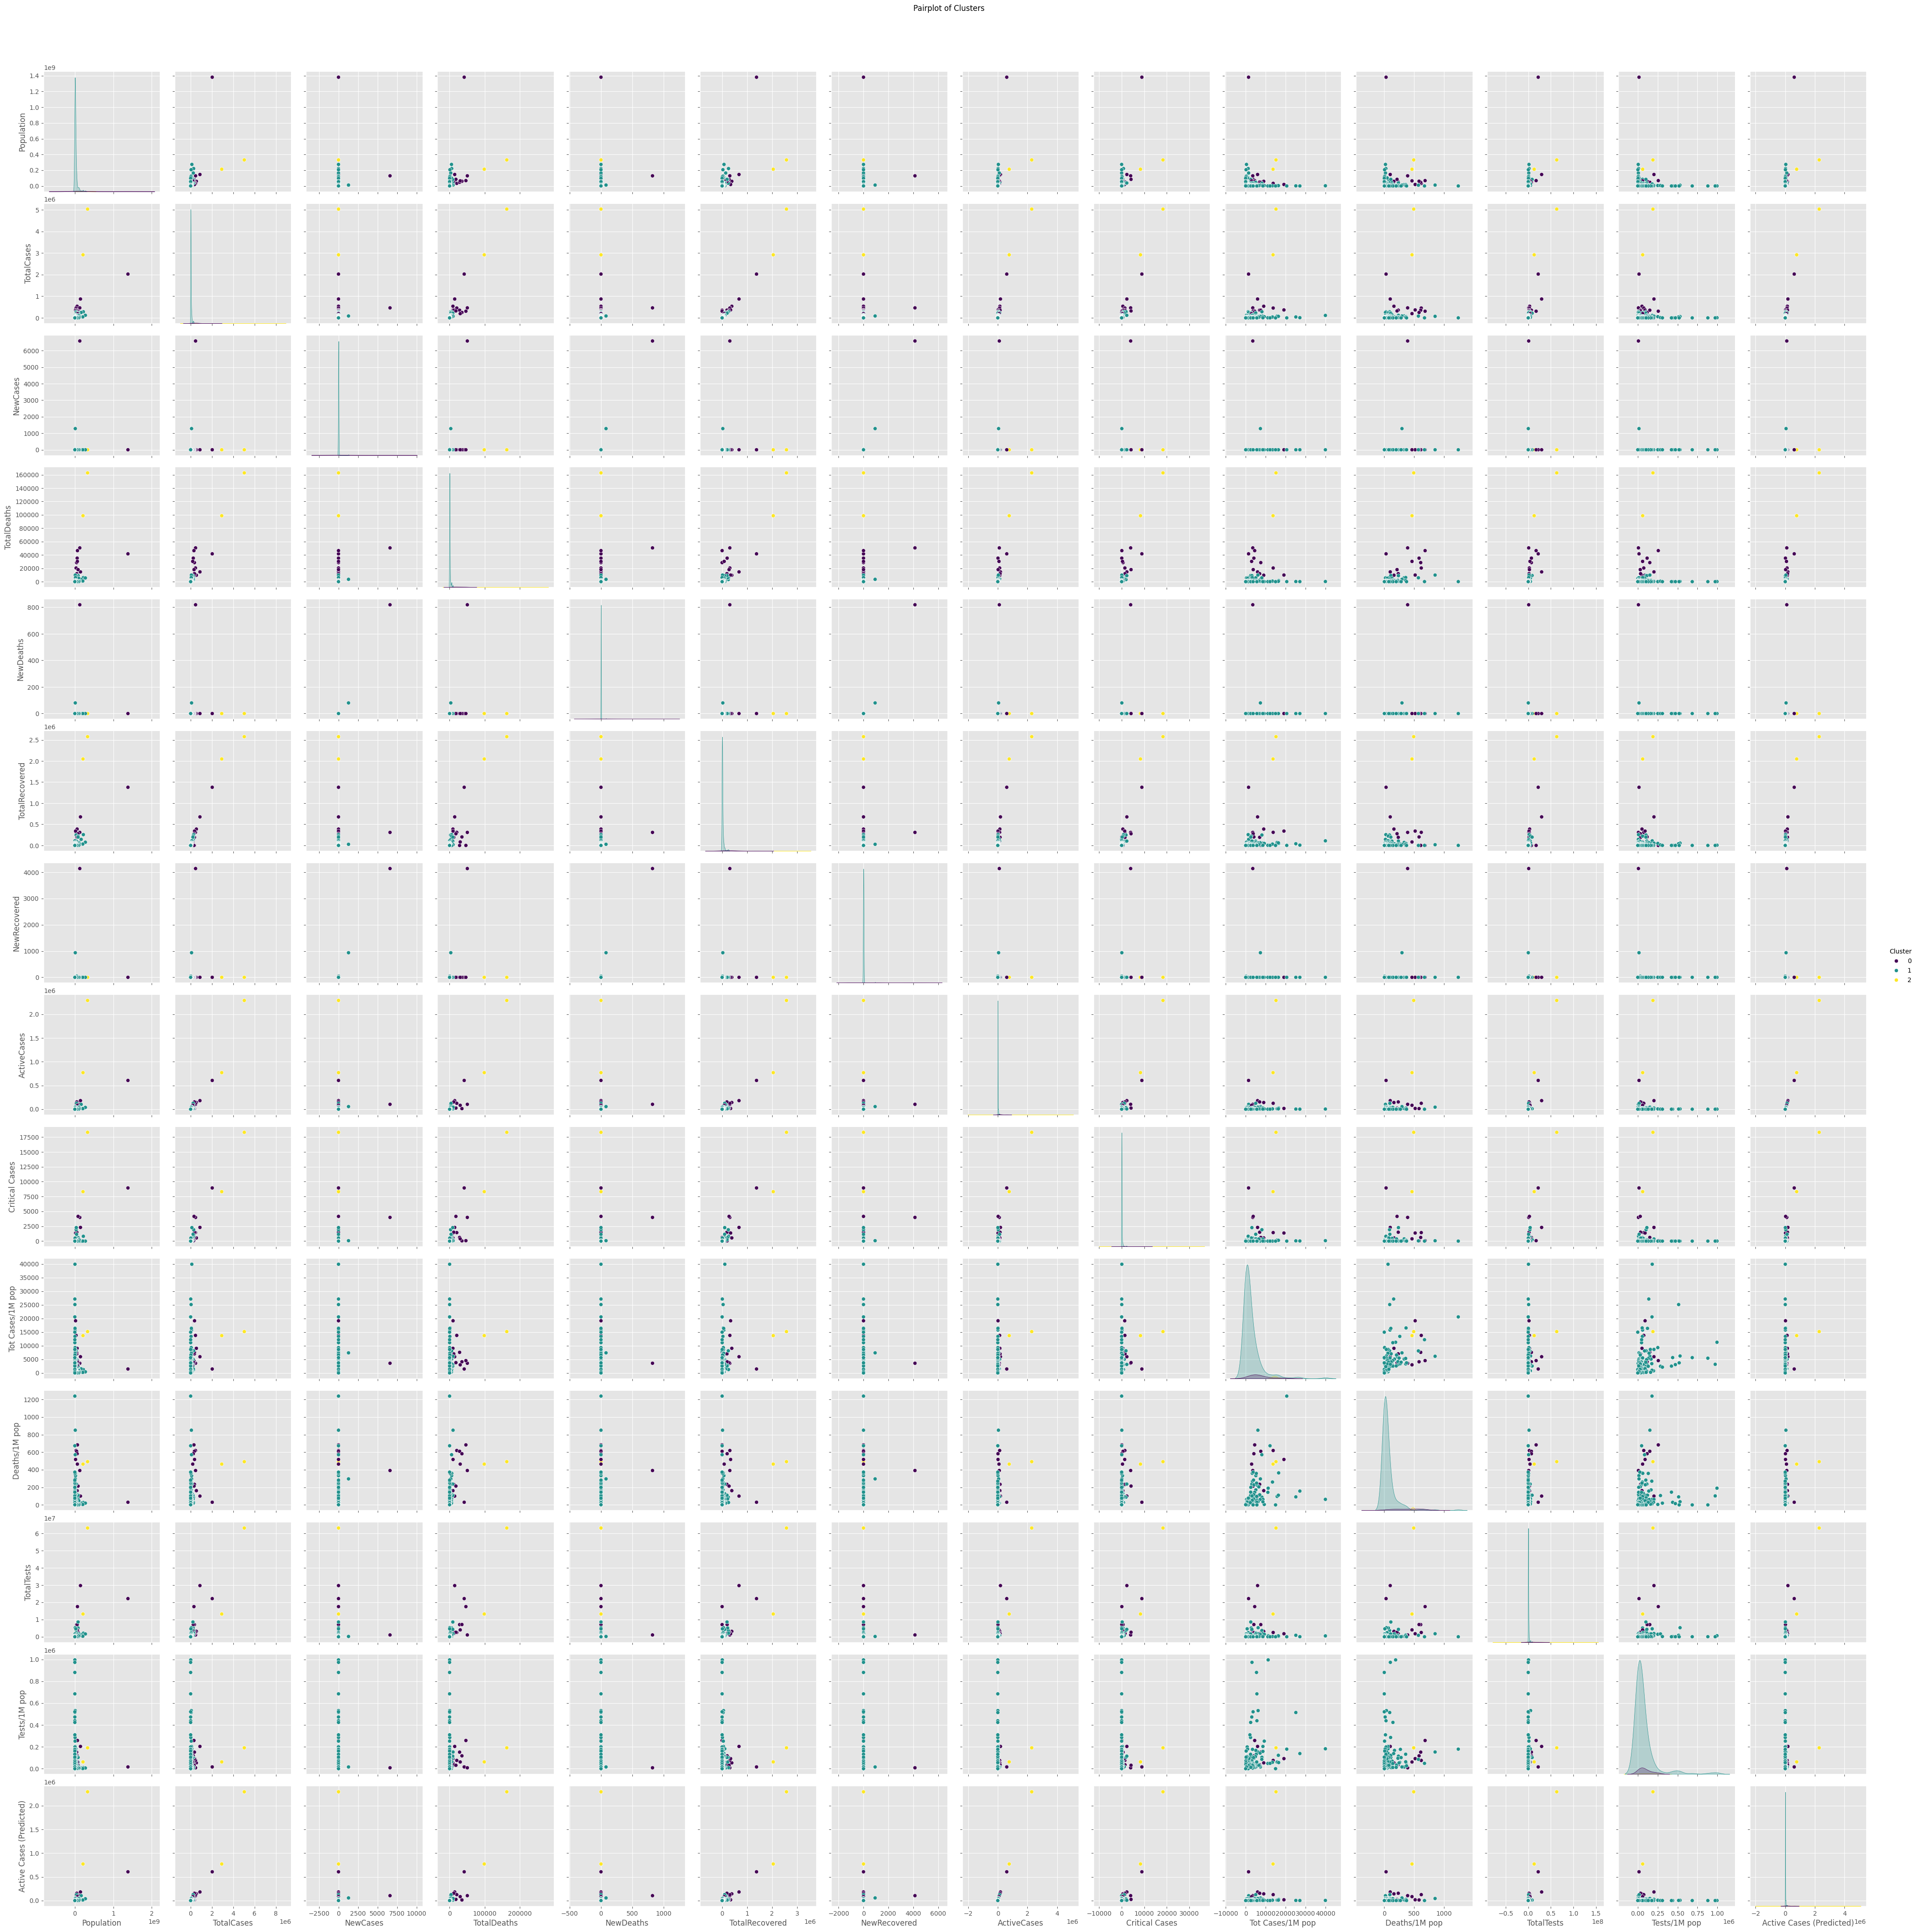

In [ ]:
kmeanscolumns = ['TotalCases', 'TotalDeaths', 'TotalRecovered']

# Selecting relevant columns
X = data[kmeanscolumns]

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, 11), inertia, marker='o')
plt.title('K means clusters using elbow method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Taking optimal clusters as 3
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster labels to the Data
data['Cluster'] = clusters

sns.pairplot(data=data, hue='Cluster', palette='viridis', diag_kind='kde', height=3)
plt.suptitle('Pairplot of Clusters', y=1.02)
plt.savefig('Kmeansclusters.png')
plt.show()

                             Creating a linear regression model and training it on our dataset

Linear Regression for Total Cases vs Total Deaths

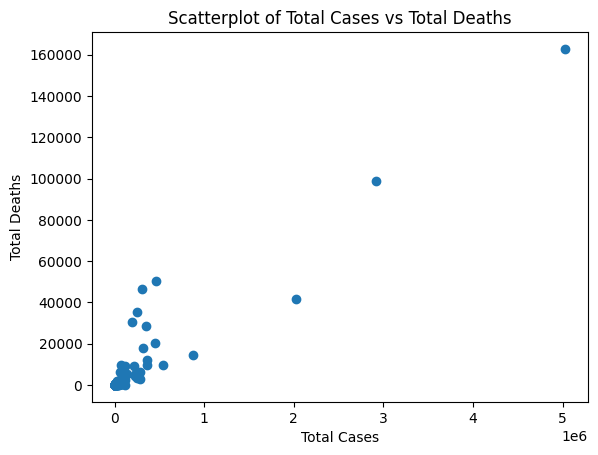

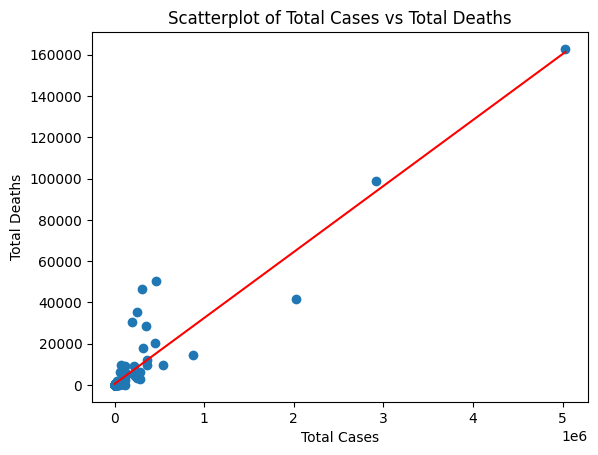

The accuracy of Model is:  88.16066577009316


array([[15791.06200799]])

In [ ]:
plt.scatter(data['TotalCases'],data['TotalDeaths'] )
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Scatterplot of Total Cases vs Total Deaths')
plt.show()



x = data['TotalCases']
y = data['TotalDeaths']

x = np.array(x)
y= np.array(y)

x=x.reshape(-1,1)
y=y.reshape(-1,1)

regressor = LinearRegression()
regressor.fit(x,y) 

yp= regressor.predict(x)
plt.scatter(x,y)
plt.plot(x,yp, color = 'r' )

plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Scatterplot of Total Cases vs Total Deaths')
plt.show()


print("The accuracy of Model is: ",regressor.score(x,y)*100)

regressor.predict([[478947]])

Linear Regression for Active Cases vs Critical Cases

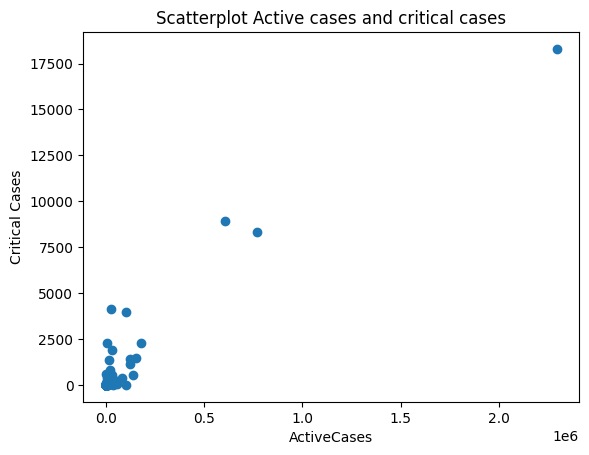

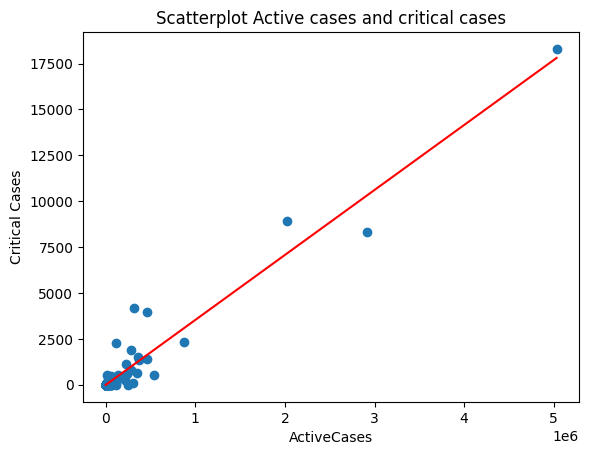

The accuracy of Model is:  93.52744616809281


array([[266.7207423]])

In [ ]:
pl = plt.scatter(data['ActiveCases'],data['Critical Cases'] )
plt.xlabel('ActiveCases')
plt.ylabel('Critical Cases')
plt.title('Scatterplot Active cases and Critical cases')
plt.show()

X = data['ActiveCases']
y = data['Critical Cases']

x = np.array(x)
y= np.array(y)

x=x.reshape(-1,1)
y=y.reshape(-1,1)


regressor = LinearRegression()
regressor.fit(x,y) 

yp= regressor.predict(x)

plt.scatter(x,y)
plt.plot(x,yp,color = 'r')
plt.xlabel('ActiveCases')
plt.ylabel('Critical Cases')
plt.title('Scatterplot Active cases and Critical cases')
plt.show()

print("The accuracy of Model is: ",regressor.score(x,y)*100)

regressor.predict([[78947]])